In [1]:
#import all essential libraries
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL

In [2]:
from sklearn.metrics import mean_squared_error,r2_score
## Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM

from keras.layers import Dropout

Using TensorFlow backend.


In [3]:
data = pd.read_csv('data/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [4]:
data.columns[data.isnull().any()]

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [5]:
import matplotlib.pyplot as plt
import matplotlib

def get_acf(data,lags): 
    frame = []
    for i in range(lags+1):
        frame.append(data.apply(lambda col: col.autocorr(i), axis=0))
    return pd.DataFrame(frame).plot.line()
get_acf(data,10)

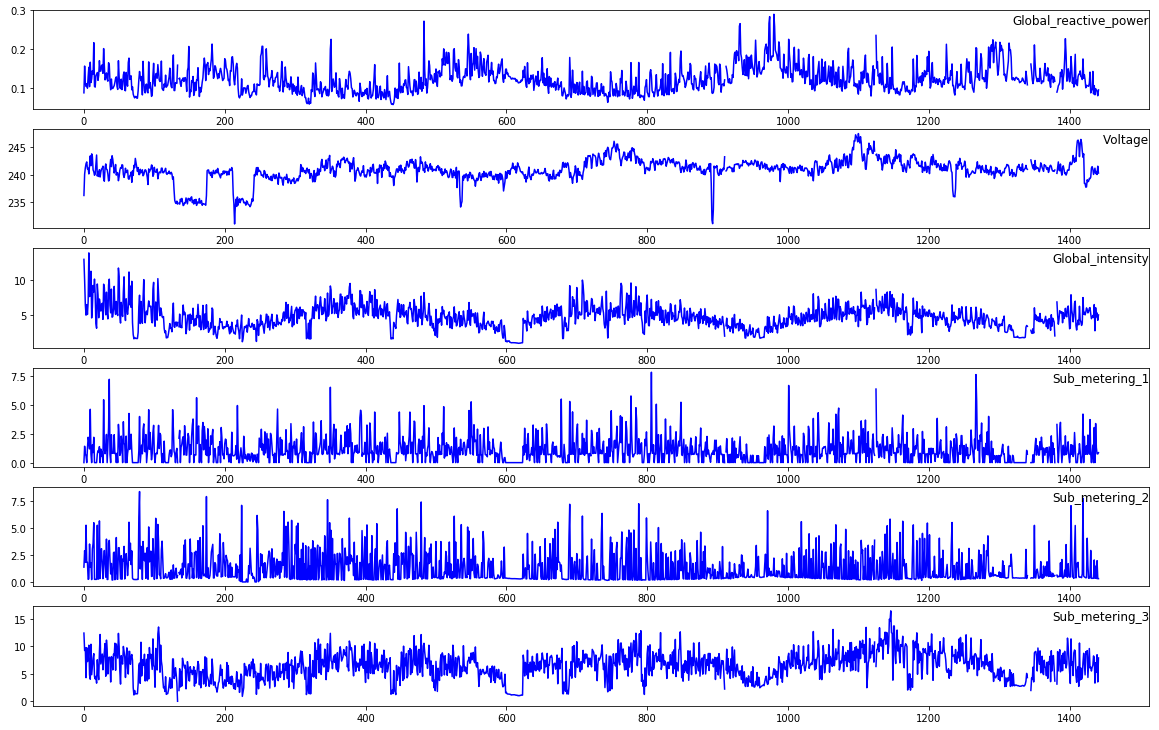

In [6]:
#fill in missing values using linear interpolation with limit to 10 using autocorelation plot
clean_data = data.interpolate(method = 'linear', axis = 0, limit = 10)

i = 1
# plot each column
plt.figure(figsize=(20, 15))
for counter in range(1,len(clean_data.columns)):
    plt.subplot(len(clean_data.columns), 1, i)
    plt.plot(clean_data.resample('D').mean().values[:, counter], color = 'blue')
    plt.title(clean_data.columns[counter], y=0.8, loc='right')
    i = i+1
plt.show()

In [7]:
import seaborn as sns # used for plot interactive graph. 

#check corelation matrices for minute, hour and day
#minute
corr_min = clean_data.corr()
#hour
corr_hour = pd.DataFrame(clean_data.resample('H').mean().values).corr()
#day
corr_day = pd.DataFrame(clean_data.resample('D').mean().values).corr()
cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]
#Plot Minute
corr_min.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())



,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1,0.25,-0.4,1,0.48,0.43,0.64
Global_reactive_power,0.25,1,-0.11,0.27,0.12,0.14,0.09
Voltage,-0.4,-0.11,1,-0.41,-0.2,-0.17,-0.27
Global_intensity,1,0.27,-0.41,1,0.49,0.44,0.63
Sub_metering_1,0.48,0.12,-0.2,0.49,1,0.055,0.1
Sub_metering_2,0.43,0.14,-0.17,0.44,0.055,1,0.081
Sub_metering_3,0.64,0.09,-0.27,0.63,0.1,0.081,1


In [8]:
corr_hour.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,0,1,2,3,4,5,6
0,1,0.31,-0.38,1,0.5,0.44,0.7
1,0.31,1,-0.15,0.33,0.33,0.26,0.1
2,-0.38,-0.15,1,-0.39,-0.21,-0.16,-0.28
3,1,0.33,-0.39,1,0.5,0.45,0.69
4,0.5,0.33,-0.21,0.5,1,0.12,0.2
5,0.44,0.26,-0.16,0.45,0.12,1,0.12
6,0.7,0.1,-0.28,0.69,0.2,0.12,1


In [9]:
corr_day.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,0,1,2,3,4,5,6
0,1,0.039,0.11,1,0.54,0.47,0.73
1,0.039,1,-0.057,0.061,0.32,0.18,0.027
2,0.11,-0.057,1,0.087,-0.07,-0.078,0.17
3,1,0.061,0.087,1,0.55,0.48,0.72
4,0.54,0.32,-0.07,0.55,1,0.25,0.3
5,0.47,0.18,-0.078,0.48,0.25,1,0.2
6,0.73,0.027,0.17,0.72,0.3,0.2,1


In [10]:
#Credit: Adopted from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [79]:
resampled_data = clean_data.resample('H').mean() 

In [80]:
reframed_data = series_to_supervised(resampled_data, 3, 1)
print(reframed_data.head())

                     var1(t-3)  var2(t-3)   var3(t-3)  var4(t-3)  var5(t-3)  \
dt                                                                            
2006-12-16 20:00:00   4.222889   0.229000  234.643889  18.100000        0.0   
2006-12-16 21:00:00   3.632200   0.080033  234.580167  15.600000        0.0   
2006-12-16 22:00:00   3.400233   0.085233  233.232500  14.503333        0.0   
2006-12-16 23:00:00   3.268567   0.075100  234.071500  13.916667        0.0   
2006-12-17 00:00:00   3.056467   0.076667  237.158667  13.046667        0.0   

                     var6(t-3)  var7(t-3)  var1(t-2)  var2(t-2)   var3(t-2)  \
dt                                                                            
2006-12-16 20:00:00   0.527778  16.861111   3.632200   0.080033  234.580167   
2006-12-16 21:00:00   6.716667  16.866667   3.400233   0.085233  233.232500   
2006-12-16 22:00:00   1.433333  16.683333   3.268567   0.075100  234.071500   
2006-12-16 23:00:00   0.000000  16.783333   3.05646

In [81]:
reframed_data.drop(reframed_data.columns[-6:], axis=1, inplace=True)

In [82]:
print(reframed_data.columns)

Index(['var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)', 'var5(t-3)',
       'var6(t-3)', 'var7(t-3)', 'var1(t-2)', 'var2(t-2)', 'var3(t-2)',
       'var4(t-2)', 'var5(t-2)', 'var6(t-2)', 'var7(t-2)', 'var1(t-1)',
       'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)',
       'var7(t-1)', 'var1(t)'],
      dtype='object')


In [83]:
values = reframed_data.values
#The logic is to have 500 days worth of training data. this could also be a hyperparameter that can be tuned.
train_index = 500*24 
train = values[:train_index, :]
test = values[train_index:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 3, int(train_X.shape[1]/3)))
test_X = test_X.reshape((test_X.shape[0], 3, int(test_X.shape[1]/3)))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(12000, 3, 7) (12000,) (22145, 3, 7) (22145,)


Train on 12000 samples, validate on 22145 samples
Epoch 1/10
12000/12000 [==============================] - 17s 1ms/step - loss: 0.6478 - val_loss: 0.3852
Epoch 2/10
12000/12000 [==============================] - 12s 1ms/step - loss: 0.4826 - val_loss: 0.3546
Epoch 3/10
12000/12000 [==============================] - 12s 997us/step - loss: 0.4698 - val_loss: 0.3475
Epoch 4/10
12000/12000 [==============================] - 12s 991us/step - loss: 0.4627 - val_loss: 0.3524
Epoch 5/10
12000/12000 [==============================] - 12s 992us/step - loss: 0.4527 - val_loss: 0.3435
Epoch 6/10
12000/12000 [==============================] - 12s 1ms/step - loss: 0.4479 - val_loss: 0.3539
Epoch 7/10
12000/12000 [==============================] - 12s 991us/step - loss: 0.4450 - val_loss: 0.3443
Epoch 8/10
12000/12000 [==============================] - 12s 983us/step - loss: 0.4405 - val_loss: 0.3719
Epoch 9/10
12000/12000 [==============================] - 12s 1ms/step - loss: 0.4403 - val_loss: 0.

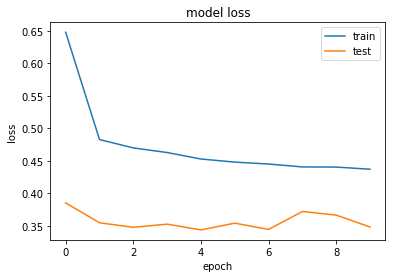

In [90]:
from keras.layers import Embedding
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=((3, train_X.shape[2]))))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=10, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [91]:
yhat = model.predict(train_X, verbose=0)
rmse_train = np.sqrt(mean_squared_error(train_y, yhat))
yhat = model.predict(test_X, verbose=0)
rmse_test = np.sqrt(mean_squared_error(test_y, yhat))
print('Train RMSE: %.3f' % rmse_train)
print('Test RMSE: %.3f' % rmse_test)

Train RMSE: 0.675
Test RMSE: 0.590


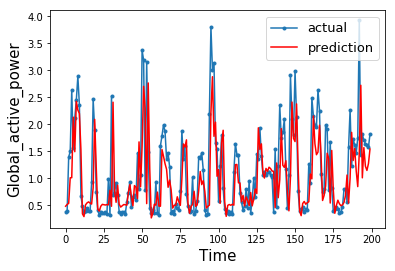

In [92]:
aa=[x for x in range(200)]
plt.plot(aa, test_y[:200], marker='.', label="actual")
plt.plot(aa, yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time', size=15)
plt.legend(fontsize=13)
plt.show()